<a href="https://colab.research.google.com/github/abnr/hemodynamic/blob/main/Hemodynamic_spectral_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install  connectivipy

  Created wheel for connectivipy: filename=connectivipy-0.36-py3-none-any.whl size=23679 sha256=64bea14bfe62df74efe740d212ba9bfb4b1a09fd5ba01601fbcb5d0c54a2785f
  Stored in directory: /root/.cache/pip/wheels/6d/e8/99/6262a8d13d9f1ef90bacd3acedfeb0b76fd5f0f359a5d59ff2
Successfully built connectivipy


In [ ]:
from scipy.io import loadmat
from scipy import signal
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')
from pathlib import Path
import seaborn as sns
import pandas as pd
#from spectral_connectivity import Multitaper
#from spectral_connectivity import Connectivity
#from spectral_connectivity import multitaper_connectivity
#from mne import connectivity
import connectivipy as cp

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Hemodynamic Spectral Analysis

## Frequencies of interest
* 0.1-0.3 Hz	
* 0.3-1.5 Hz
* 1.5-3.0 Hz

> Update: 27/07/2021: considering only 0-1hz

## Ratos
* 1448
* 1564
* 1594
* 1596
* 1696
* 1449
* 1513
* 1514
* 1565

## Pré-Processamento

Filtr FIR 0.1 até 10Hz, ordem 100.

In [ ]:
ratos = [ '1448', '1564', '1594', '1596', '1696', '1449', '1513', '1514', '1565' ]
janelas = ['j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'j7', 'j8', 'j9', 'j10' ]
nperseg = 40000
serie1 = [ 0, 0, 1, 1, 0, 0, 1, 1, 1 ]
serie2 = [1, 1, 0, 0, 1, 1, 0, 0, 0]

## Plotando os primeiros 1000 pontos

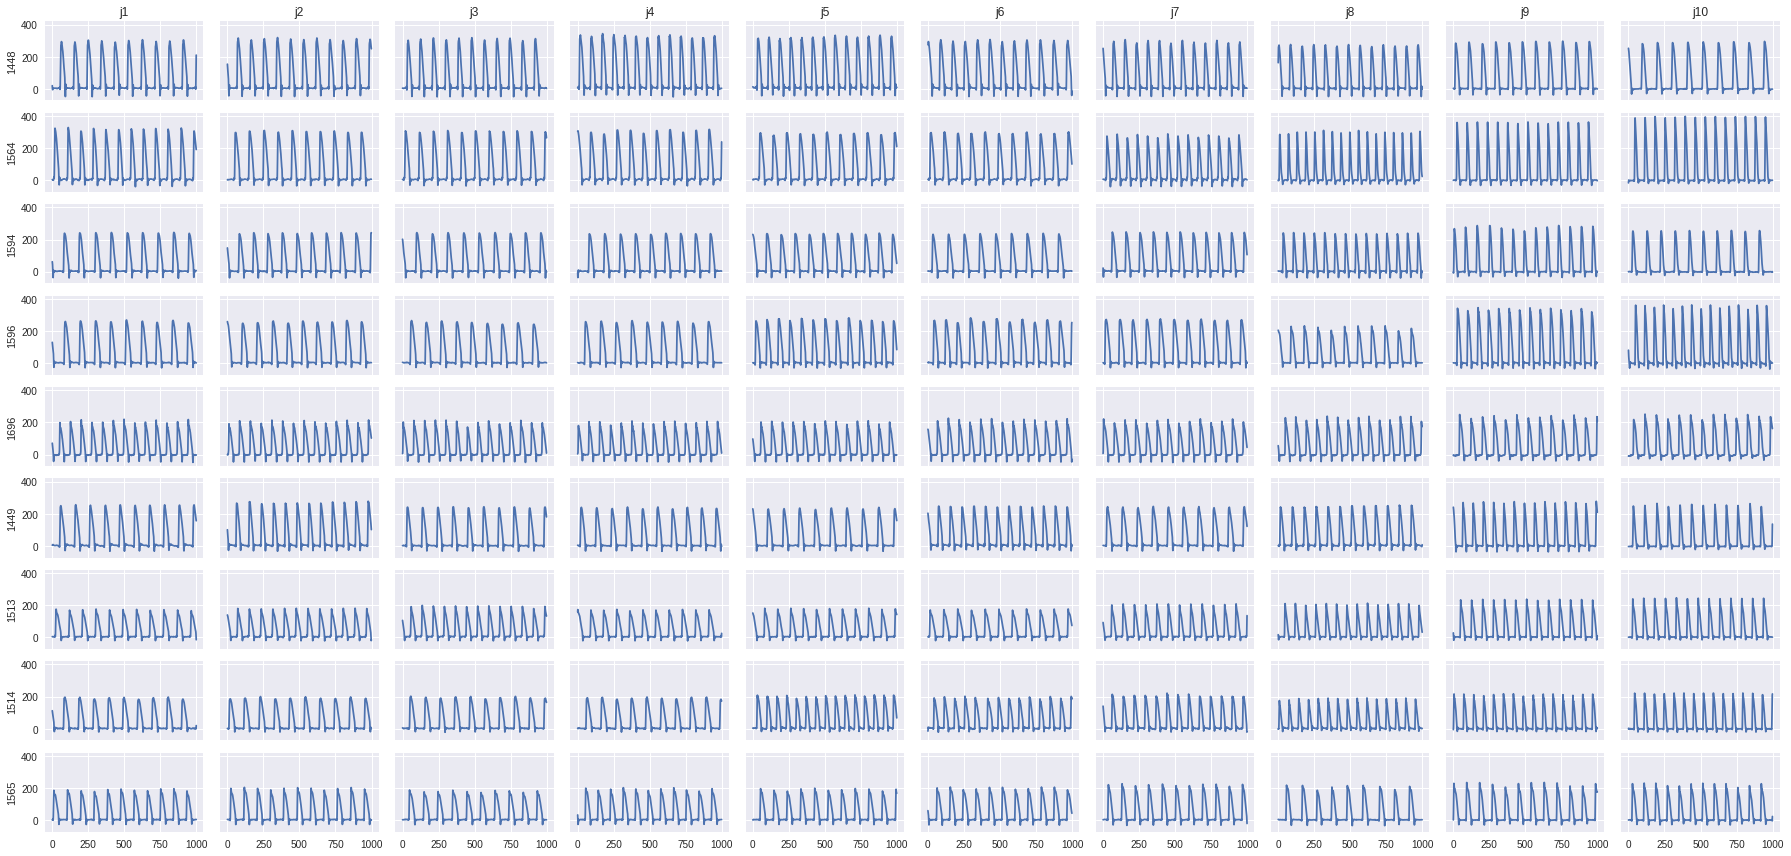

In [ ]:
# fluxo
fig, axs = plt.subplots(len(ratos), len(janelas), figsize=(25, 12), sharex=True, sharey=True)
for i in range(len(ratos)):
    for j in range(len(janelas)):
        filename = '/content/drive/Shareddrives/Hemodynamic/data/' + ratos[i] + '_'+janelas[j]+'.mat'
        my_file = Path(filename)
        if my_file.is_file():
            data = loadmat(filename)
            data = data[janelas[j]]
            axs[i, j].plot( data[0:1000, serie1[i]] )

for i in range(len(ratos)):
    axs[i,0].set_ylabel(ratos[i])
for k in range(len(janelas)):
    axs[0,k].set_title(janelas[k])
plt.tight_layout()

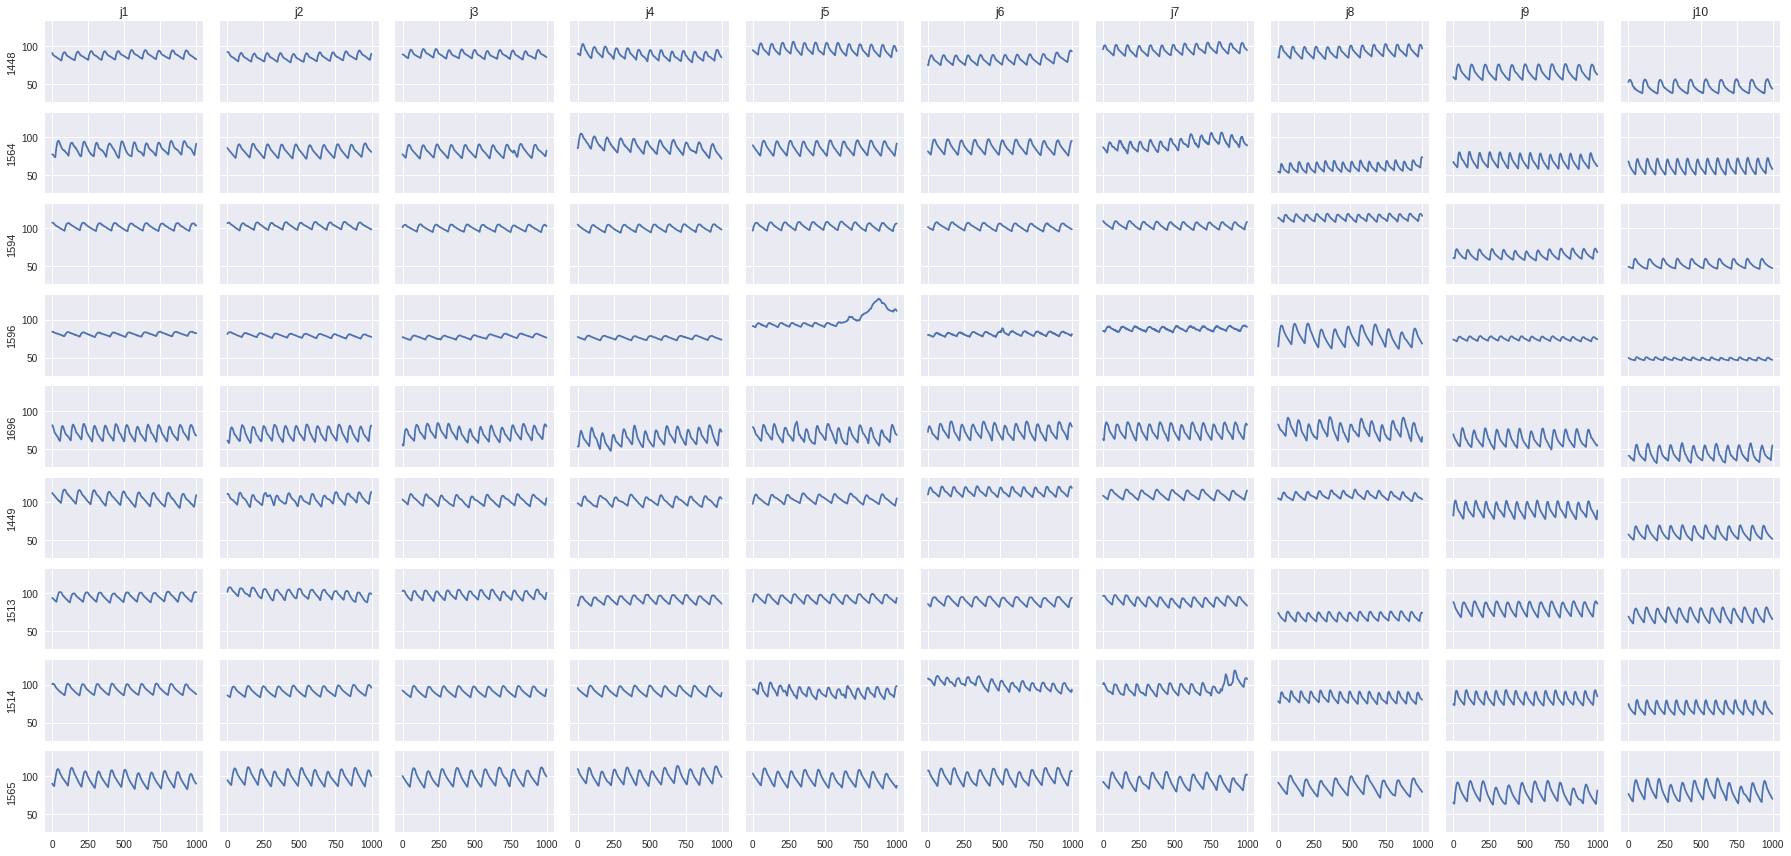

In [ ]:
#pressao

fig, axs = plt.subplots(len(ratos), len(janelas), figsize=(25, 12), sharex=True, sharey=True)
for i in range(len(ratos)):
    for j in range(len(janelas)):
        filename = '/content/drive/Shareddrives/Hemodynamic/data/' + ratos[i] + '_'+janelas[j]+'.mat'
        my_file = Path(filename)
        if my_file.is_file():
            data = loadmat(filename)
            data = data[janelas[j]]
            axs[i, j].plot( data[0:1000, serie2[i]] )

for i in range(len(ratos)):
    axs[i,0].set_ylabel(ratos[i])
for k in range(len(janelas)):
    axs[0,k].set_title(janelas[k])
plt.tight_layout()

# Calculando o Espectro

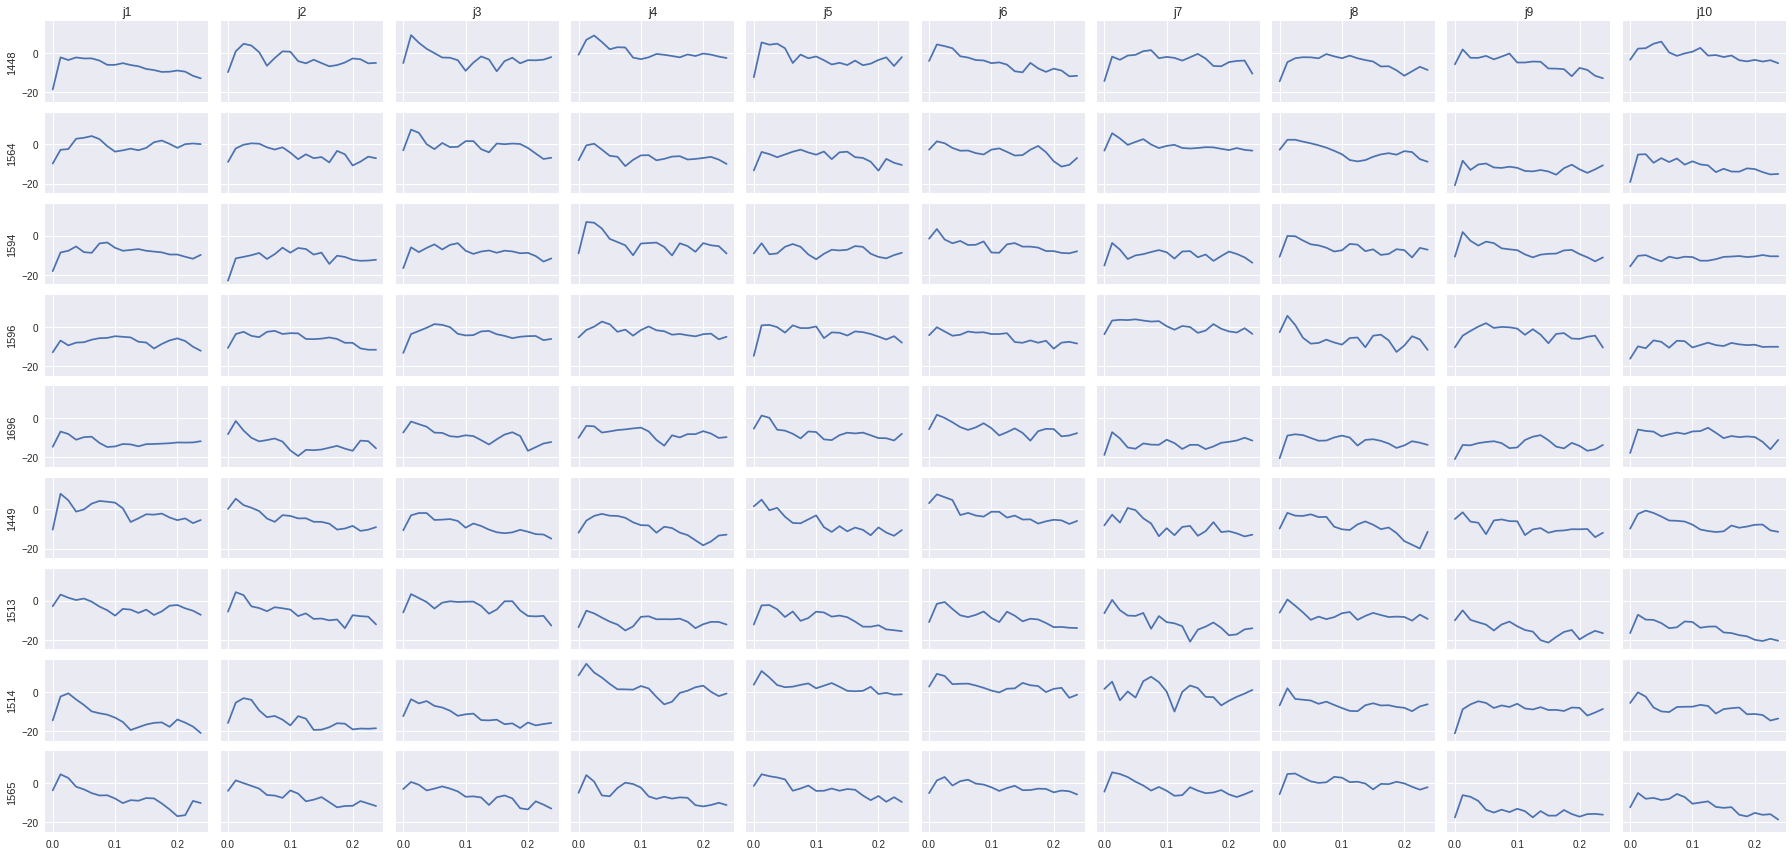

In [ ]:
fig, axs = plt.subplots(len(ratos), len(janelas), figsize=(25, 12), sharex=True, sharey=True)
h = signal.firwin(100, [0.01, 1.2], pass_zero=False, fs=500)


results = {}
for i in range(len(ratos)):
    results[ratos[i]] = {}
    results[ratos[i]]['fxx'] = []
    for j in range(len(janelas)):
        results[ratos[i]][janelas[j]] = []

for i in range(len(ratos)):
    for j in range(len(janelas)):
        filename = '/content/drive/Shareddrives/Hemodynamic/data/' + ratos[i] + '_'+janelas[j]+'.mat'
        my_file = Path(filename)
        if my_file.is_file():
            data = loadmat(filename)
            data = data[janelas[j]]
            #sinal1 = signal.filtfilt(h, 1, data[:, serie1[i]] )
            sinal1 = data[:, serie1[i]]
            f1_4096, Pxx_den1_4096 = signal.welch(sinal1, fs=500, nperseg=nperseg, detrend='constant')
            Pxx_den1_4096 = Pxx_den1_4096/np.mean(Pxx_den1_4096)
            results[ratos[i]]['fxx'].append(f1_4096)
            results[ratos[i]][janelas[j]].append(Pxx_den1_4096)
            axs[i, j].plot( f1_4096[0:20], np.log10(Pxx_den1_4096[0:20])*10 )
            #axs[i, j].plot( f1_4096[0:10], Pxx_den1_4096[0:10]/np.mean(Pxx_den1_4096[0:10]) )

for i in range(len(ratos)):
    axs[i,0].set_ylabel(ratos[i])
for k in range(len(janelas)):
    axs[0,k].set_title(janelas[k])
plt.tight_layout()

In [ ]:
espectros = {}
for j in janelas:
    espectros[j] = np.zeros( (len(ratos), results['1448']['j1'][0].shape[0]) )

for i in range(len(ratos)):
    for j in range(len(janelas)):
        espectros[janelas[j]][i, :] = results[ratos[i]][janelas[j]][0]

In [ ]:
fig, axs = plt.subplots(len(janelas), figsize=(8, 25), sharex=True, sharey=True)

for j in range(len(janelas)):
    media = np.mean(espectros[janelas[j]][:,:], axis=0);
    std_err = stats.sem(espectros[janelas[j]][:,:], axis=0  )
    axs[j].plot(results['1448']['fxx'][0][0:80], media[0:80] );
    axs[j].fill_between(results['1448']['fxx'][0][0:80], media[0:80]+std_err[0:80], media[0:80]-std_err[0:80], alpha=0.5)
    axs[j].set_title('Media da Janela ' + janelas[j] )

In [ ]:
#bandas_definition = [ [0.01, 0.3], [0.3, 1.5], [1.5, 3.0] ]
bandas_definition = [ [0.01, 0.2], [0.2, 1.0] ]
heatmaps = len(bandas_definition)
bandas = []

for banda in bandas_definition:
    banda_values = np.zeros(( len(ratos), len(janelas) ))
    for i in range(len(ratos)):
        for j in range(len(janelas)):
            low, _ = find_nearest( results[ ratos[i] ]['fxx'][0], banda[0] )
            high, _ = find_nearest( results[ ratos[i] ]['fxx'][0], banda[1] )
            banda_values[i, j] = np.mean( results[ ratos[i] ][janelas[j]][0][low:high ] )
    bandas.append( banda_values )

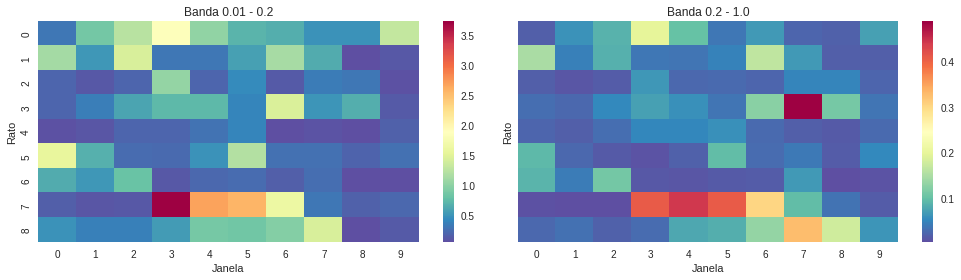

In [ ]:
fig, axs = plt.subplots(1, len(bandas_definition), figsize=(14, 4), sharex=True, sharey=True)
for i in range(len(bandas_definition)):
    sns.heatmap(bandas[i], ax=axs[i], cmap='Spectral_r')
    axs[i].set_title('Banda ' + str(bandas_definition[i][0]) + ' - ' + str(bandas_definition[i][1]) )
    axs[i].set_ylabel('Rato')
    axs[i].set_xlabel('Janela')
plt.tight_layout()

In [ ]:
df = pd.DataFrame(data=bandas[0], columns=janelas)
df.head(20)

j1        j2        j3  ...        j8        j9       j10
0  0.326109  0.874029  1.244961  ...  0.492935  0.492677  1.311663
1  1.129182  0.524007  1.444360  ...  0.656435  0.067590  0.125340
2  0.203568  0.121478  0.207500  ...  0.344339  0.316281  0.075304
3  0.203727  0.370513  0.613345  ...  0.504926  0.663331  0.132939
4  0.073517  0.102098  0.199873  ...  0.088502  0.059295  0.175941
5  1.576592  0.675232  0.249750  ...  0.274002  0.188917  0.276232
6  0.657327  0.519595  0.811983  ...  0.259520  0.061544  0.062024
7  0.164244  0.107000  0.122770  ...  0.323570  0.176232  0.223077
8  0.496185  0.373913  0.382103  ...  1.439291  0.064325  0.128234

[9 rows x 10 columns]

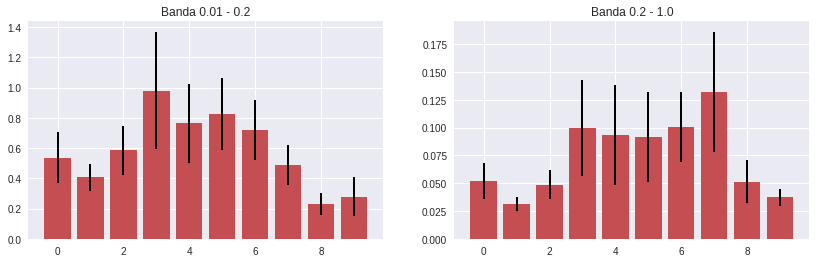

In [ ]:
fig, axs = plt.subplots(1, len(bandas_definition), figsize=(14, 4), sharex=True)

for banda in range(len(bandas)):
    for i in range(len(ratos)):
        df = pd.DataFrame(data=bandas[banda], columns=janelas)
        axs[banda].bar( np.arange(0, len(janelas), 1), df.mean(), yerr=stats.sem(df.values, axis=0) );
        axs[banda].set_title('Banda ' + str(bandas_definition[banda][0]) + ' - ' + str(bandas_definition[banda][1]) )


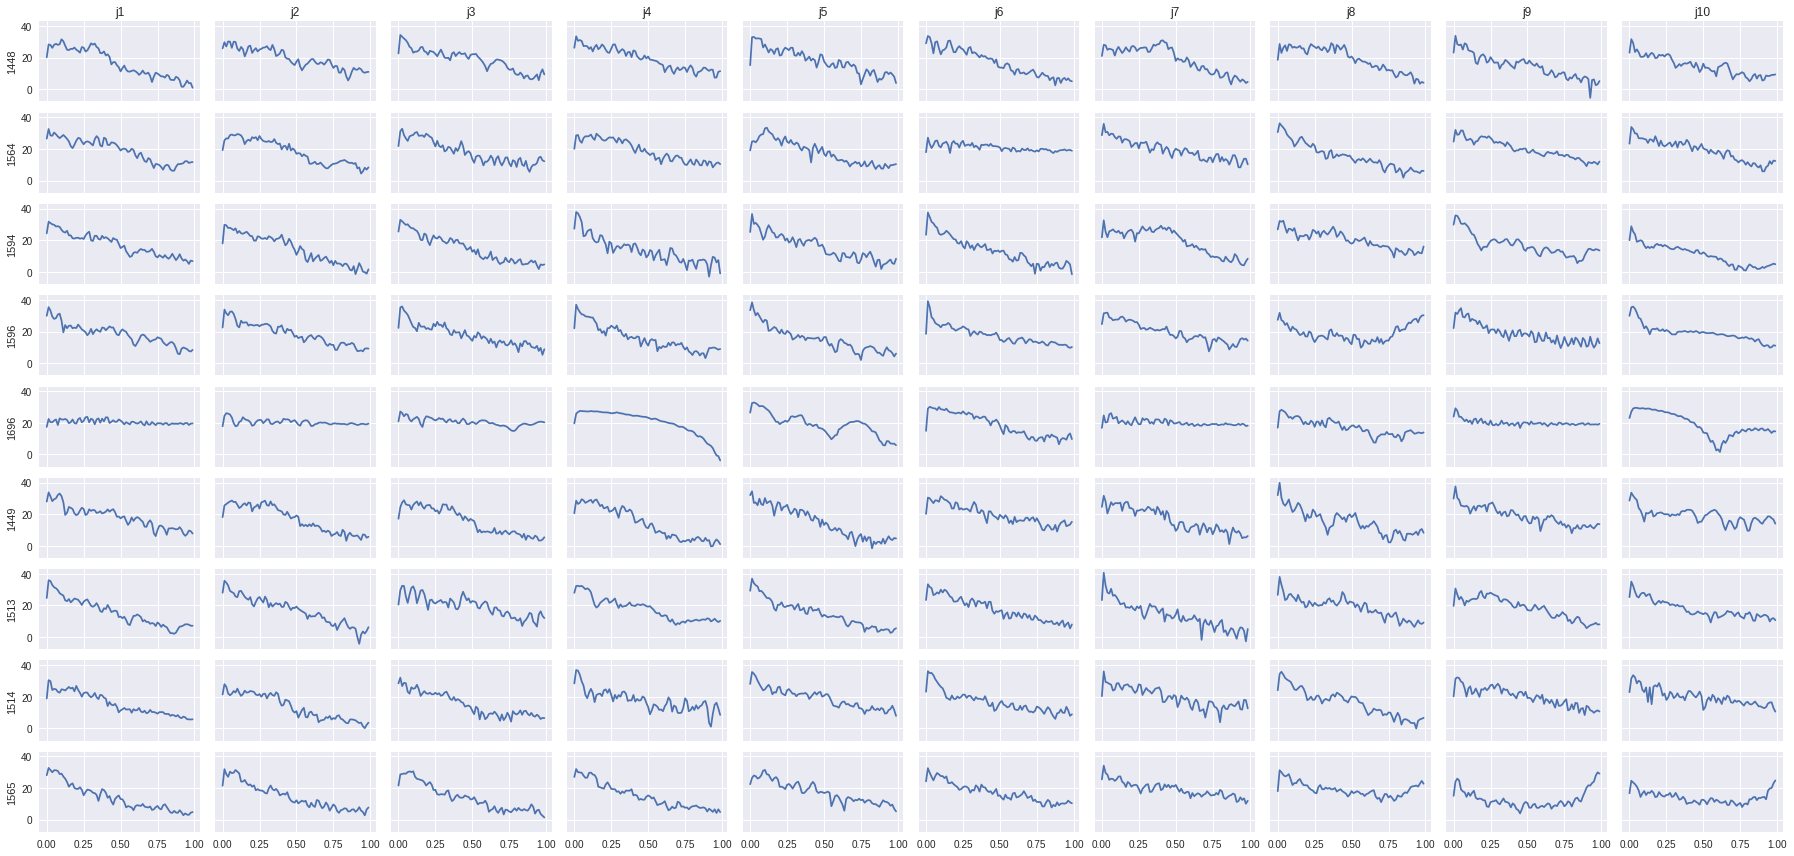

In [ ]:
fig, axs = plt.subplots(len(ratos), len(janelas), figsize=(25, 12), sharex=True, sharey=True)
h = signal.firwin(100, [0.01, 1.2], pass_zero=False, fs=500)

results = {}
for i in range(len(ratos)):
    results[ratos[i]] = {}
    results[ratos[i]]['fxx'] = []
    for j in range(len(janelas)):
        results[ratos[i]][janelas[j]] = []

for i in range(len(ratos)):
    for j in range(len(janelas)):
        filename = '/content/drive/Shareddrives/Hemodynamic/data/' + ratos[i] + '_'+janelas[j]+'.mat'
        my_file = Path(filename)
        if my_file.is_file():
            data = loadmat(filename)
            data = data[janelas[j]]

            sinal2 = signal.filtfilt(h, 1, data[:, serie2[i]] )

            f2_4096, Pxx_den2_4096 = signal.welch(sinal2, fs=500, nperseg=nperseg, detrend='constant')
            Pxx_den2_4096 = Pxx_den2_4096/np.mean(Pxx_den2_4096)
            results[ratos[i]]['fxx'].append(f2_4096)
            results[ratos[i]][janelas[j]].append(Pxx_den2_4096)
            axs[i, j].plot( f2_4096[0:80], np.log10(Pxx_den2_4096[0:80])*10 )
            
for i in range(len(ratos)):
    axs[i,0].set_ylabel(ratos[i])
for k in range(len(janelas)):
    axs[0,k].set_title(janelas[k])
plt.tight_layout()

In [ ]:
espectros = {}
for j in janelas:
    espectros[j] = np.zeros( (len(ratos), results['1448']['j1'][0].shape[0]) )

for i in range(len(ratos)):
    for j in range(len(janelas)):
        espectros[janelas[j]][i, :] = results[ratos[i]][janelas[j]][0]

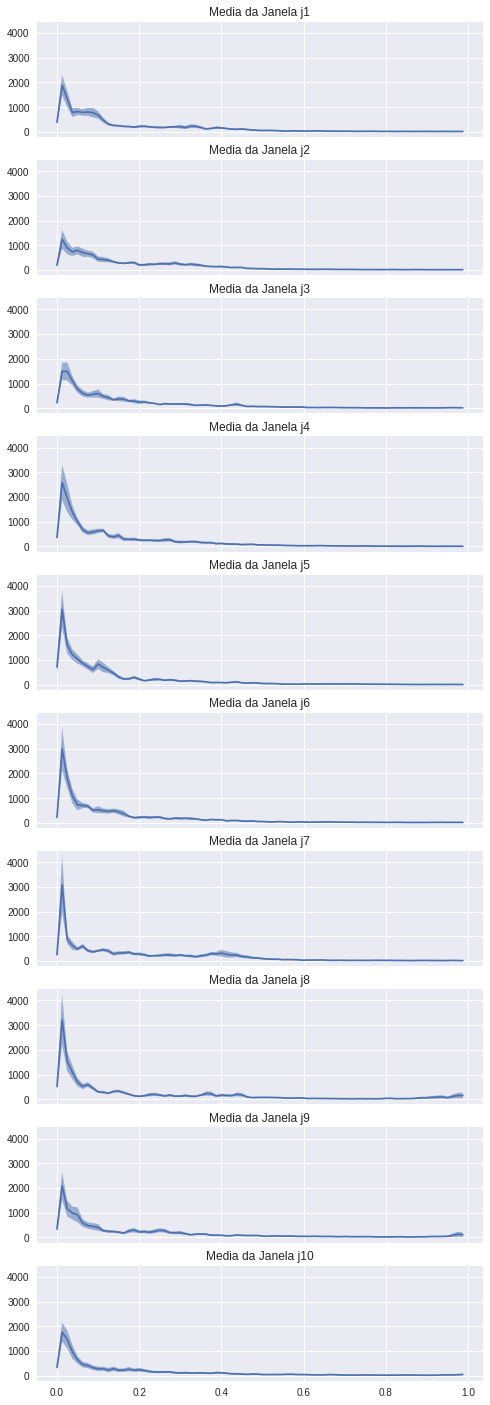

In [ ]:
fig, axs = plt.subplots(len(janelas), figsize=(8, 25), sharex=True, sharey=True)

for j in range(len(janelas)):
    media = np.mean(espectros[janelas[j]][:,:], axis=0);
    std_err = stats.sem(espectros[janelas[j]][:,:], axis=0  )
    axs[j].plot(results['1448']['fxx'][0][0:80], media[0:80] );
    axs[j].fill_between(results['1448']['fxx'][0][0:80], media[0:80]+std_err[0:80], media[0:80]-std_err[0:80], alpha=0.5)
    axs[j].set_title('Media da Janela ' + janelas[j] )

In [ ]:

heatmaps = len(bandas_definition)
bandas = []

for banda in bandas_definition:
    banda_values = np.zeros(( len(ratos), len(janelas) ))
    for i in range(len(ratos)):
        for j in range(len(janelas)):
            low, _ = find_nearest( results[ ratos[i] ]['fxx'][0], banda[0] )
            high, _ = find_nearest( results[ ratos[i] ]['fxx'][0], banda[1] )
            banda_values[i, j] = np.mean( results[ ratos[i] ][janelas[j]][0][low:high ] )
    bandas.append( banda_values )

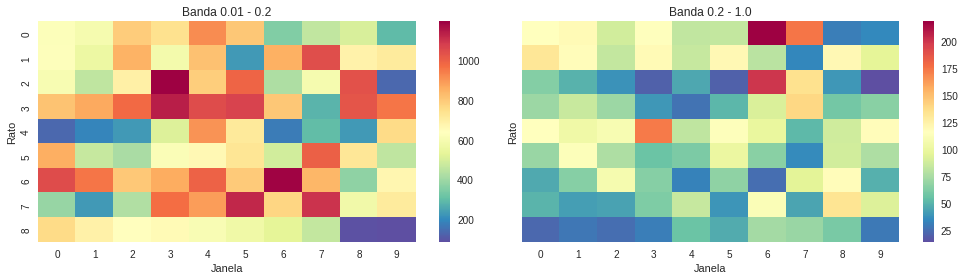

In [ ]:
fig, axs = plt.subplots(1, len(bandas_definition), figsize=(14, 4), sharex=True, sharey=True)
for i in range(len(bandas_definition)):
    sns.heatmap(bandas[i], ax=axs[i], cmap='Spectral_r')
    axs[i].set_title('Banda ' + str(bandas_definition[i][0]) + ' - ' + str(bandas_definition[i][1]) )
    axs[i].set_ylabel('Rato')
    axs[i].set_xlabel('Janela')
plt.tight_layout()

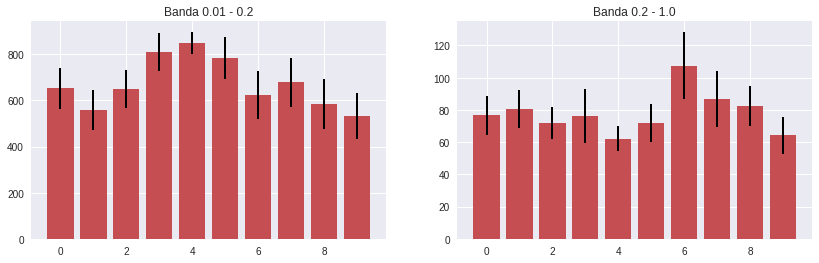

In [ ]:
fig, axs = plt.subplots(1, len(bandas_definition), figsize=(14, 4), sharex=True)

for banda in range(len(bandas)):
    for i in range(len(ratos)):
        df = pd.DataFrame(data=bandas[banda], columns=janelas)
        axs[banda].bar( np.arange(0, len(janelas), 1), df.mean(), yerr=stats.sem(df.values, axis=0) );
        axs[banda].set_title('Banda ' + str(bandas_definition[banda][0]) + ' - ' + str(bandas_definition[banda][1]) )


In [ ]:
df.head()

j1         j2         j3  ...         j8         j9        j10
0  37.839905  33.131691  30.698410  ...  43.744569  48.615630  46.025149
1  35.230948  39.113358  34.505705  ...   8.908119  47.062701  48.341843
2  43.831164  44.344134  43.937246  ...  37.540750  43.763515  48.311127
3  34.589327  26.089031  12.763289  ...  40.964456   7.158397  37.119149
4  26.802107  33.280869  31.862124  ...  37.962594  33.244543   4.303245

[5 rows x 10 columns]

# Coerência

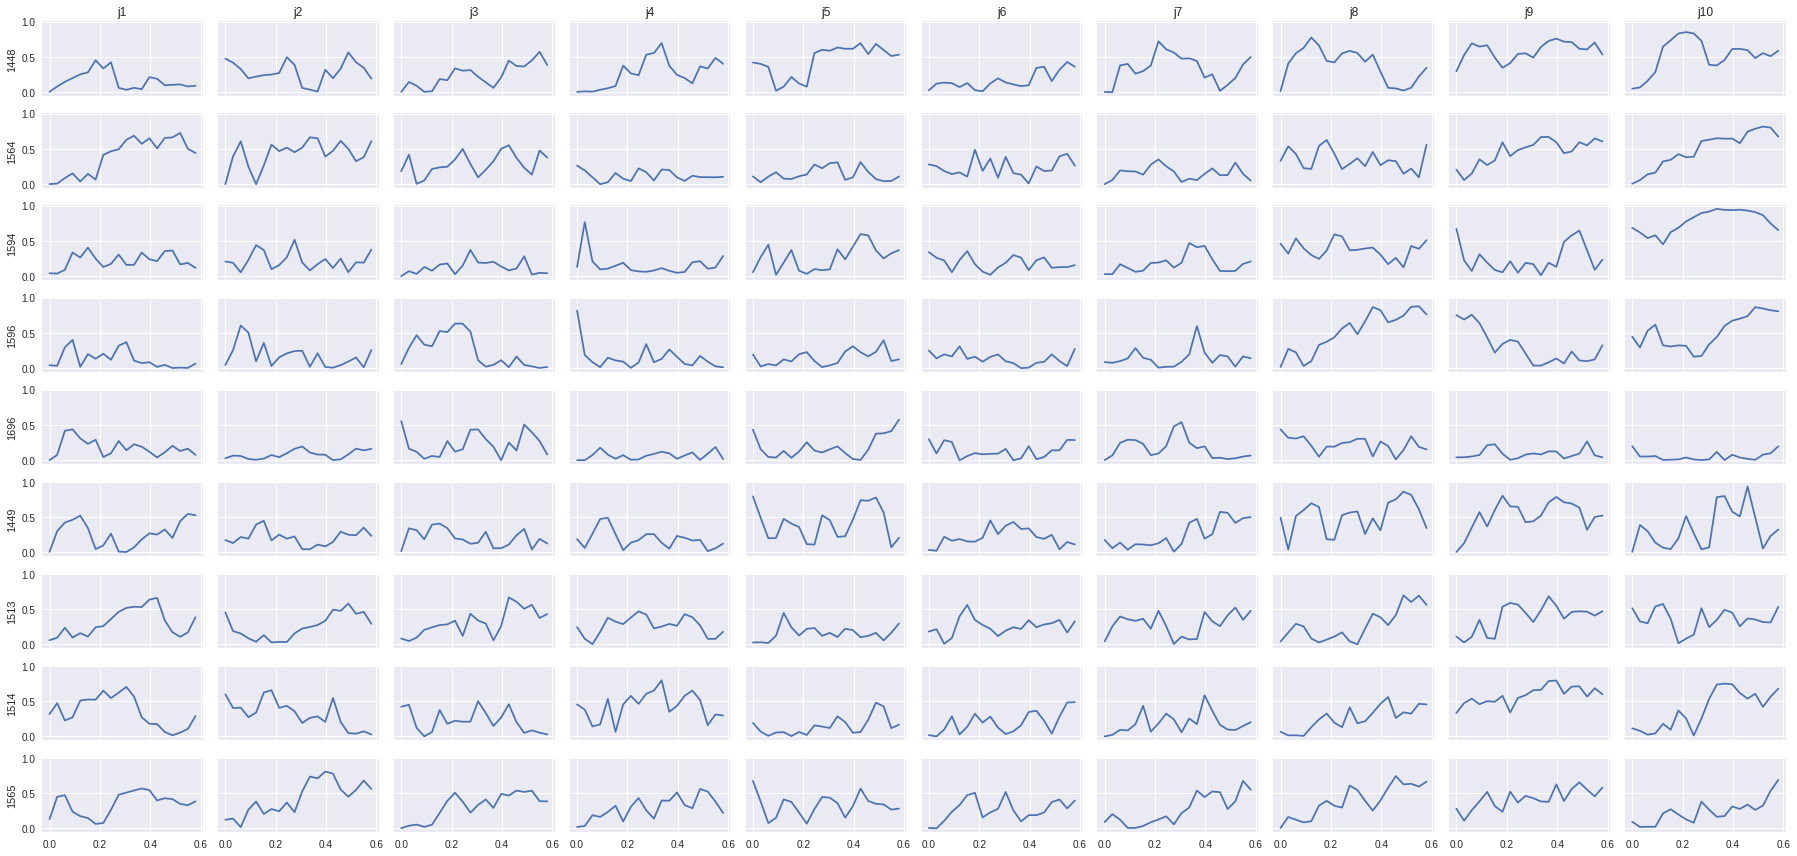

In [ ]:
fig, axs = plt.subplots(len(ratos), len(janelas), figsize=(25, 12), sharex=True, sharey=True)
h = signal.firwin(100, [0.01, 1.2], pass_zero=False, fs=500)

results = {}
for i in range(len(ratos)):
    results[ratos[i]] = {}
    results[ratos[i]]['fxx'] = []
    for j in range(len(janelas)):
        results[ratos[i]][janelas[j]] = []

for i in range(len(ratos)):
    for j in range(len(janelas)):
        filename = '/content/drive/Shareddrives/Hemodynamic/data/' + ratos[i] + '_'+janelas[j]+'.mat'
        my_file = Path(filename)
        if my_file.is_file():
            data = loadmat(filename)
            data = data[janelas[j]]
            sinal1 = signal.filtfilt(h, 1, data[:, serie1[i]] )
            sinal2 = signal.filtfilt(h, 1, data[:, serie2[i]] )

            f, Cxy = signal.coherence(sinal1, sinal2, 500, nperseg=4096*4)

            results[ratos[i]]['fxx'].append(f)
            results[ratos[i]][janelas[j]].append(Cxy)
            axs[i, j].plot( f[0:20], Cxy[0:20])

for i in range(len(ratos)):
    axs[i,0].set_ylabel(ratos[i])
for k in range(len(janelas)):
    axs[0,k].set_title(janelas[k])
plt.tight_layout()

In [ ]:
results['1448']['fxx'][0][33]

1.007080078125

In [ ]:
results_save = {}
results_save['freq'] = results['1448']['fxx'][0][0:33]
for janela in janelas:
    for key in results.keys():
        results_save[str(key) + janela] = results[key][janela][0][0:33]
pd.DataFrame.from_dict(results_save).to_csv('coh_16384.csv')

In [ ]:
espectros = {}
for j in janelas:
    espectros[j] = np.zeros( (len(ratos), results['1448']['j1'][0].shape[0]) )

for i in range(len(ratos)):
    for j in range(len(janelas)):
        espectros[janelas[j]][i, :] = results[ratos[i]][janelas[j]][0]

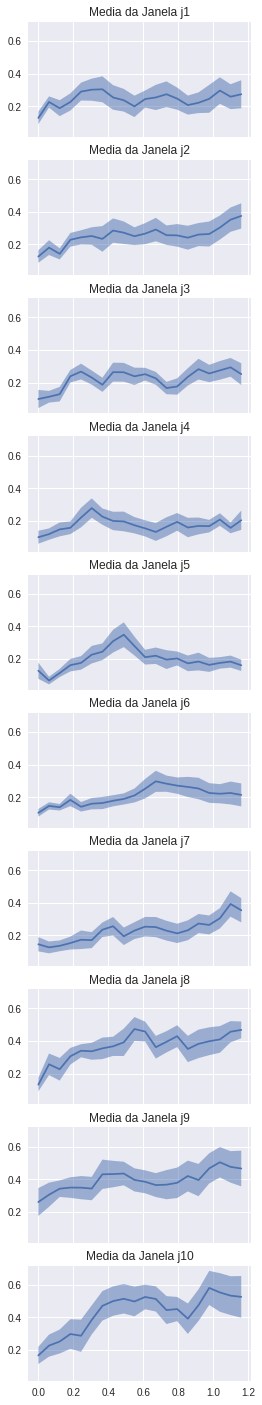

In [ ]:
fig, axs = plt.subplots(len(janelas), figsize=(4, 25), sharex=True, sharey=True)

for j in range(len(janelas)):
    media = np.mean(espectros[janelas[j]][:,:], axis=0);
    std_err = stats.sem(espectros[janelas[j]][:,:], axis=0  )
    axs[j].plot(results['1448']['fxx'][0][0:20], media[0:20] );
    axs[j].fill_between(results['1448']['fxx'][0][0:20], media[0:20]+std_err[0:20], media[0:20]-std_err[0:20], alpha=0.5)
    axs[j].set_title('Media da Janela ' + janelas[j] )

In [ ]:
heatmaps = len(bandas_definition)
bandas = []

for banda in bandas_definition:
    banda_values = np.zeros(( len(ratos), len(janelas) ))
    for i in range(len(ratos)):
        for j in range(len(janelas)):
            low, _ = find_nearest( results[ ratos[i] ]['fxx'][0], banda[0] )
            high, _ = find_nearest( results[ ratos[i] ]['fxx'][0], banda[1] )
            banda_values[i, j] = np.mean( results[ ratos[i] ][janelas[j]][0][low:high ] )
    bandas.append( banda_values )

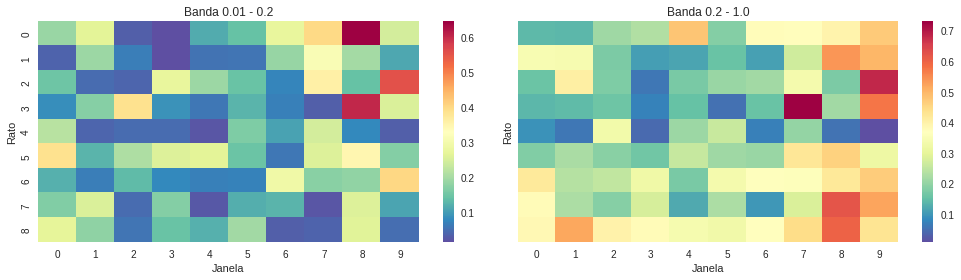

In [ ]:
fig, axs = plt.subplots(1, len(bandas_definition), figsize=(14, 4), sharex=True, sharey=True)
for i in range(len(bandas_definition)):
    sns.heatmap(bandas[i], ax=axs[i], cmap='Spectral_r')
    axs[i].set_title('Banda ' + str(bandas_definition[i][0]) + ' - ' + str(bandas_definition[i][1]) )
    axs[i].set_ylabel('Rato')
    axs[i].set_xlabel('Janela')
plt.tight_layout()

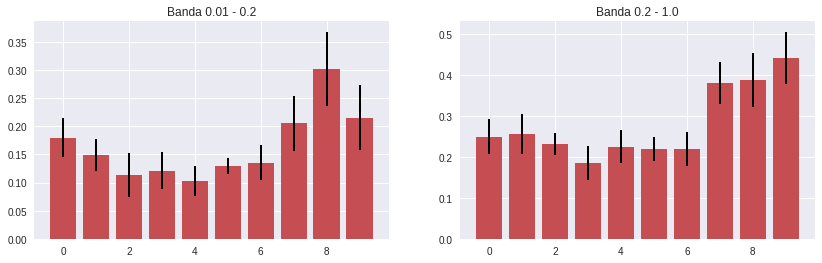

In [ ]:
fig, axs = plt.subplots(1, len(bandas_definition), figsize=(14, 4), sharex=True)

for banda in range(len(bandas)):
    for i in range(len(ratos)):
        df = pd.DataFrame(data=bandas[banda], columns=janelas)
        axs[banda].bar( np.arange(0, len(janelas), 1), df.mean(), yerr=stats.sem(df.values, axis=0) );
        axs[banda].set_title('Banda ' + str(bandas_definition[banda][0]) + ' - ' + str(bandas_definition[banda][1]) )


# PDC

In [ ]:
#fig, axs = plt.subplots(len(ratos), len(janelas), figsize=(25, 12), sharex=True, sharey=True)
h = signal.firwin(100, [0.01, 1.2], pass_zero=False, fs=500)

results = {}
for i in range(len(ratos)):
    results[ratos[i]] = {}
    results[ratos[i]]['fxx'] = []
    for j in range(len(janelas)):
        results[ratos[i]][janelas[j]] = []

results2 = {}
for i in range(len(ratos)):
    results2[ratos[i]] = {}
    results2[ratos[i]]['fxx'] = []
    for j in range(len(janelas)):
        results2[ratos[i]][janelas[j]] = []

for i in range(len(ratos)):
    for j in range(len(janelas)):
        filename = '/content/drive/Shareddrives/Hemodynamic/data/' + ratos[i] + '_'+janelas[j]+'.mat'
        my_file = Path(filename)
        if my_file.is_file():
            data = loadmat(filename)
            data = data[janelas[j]]
            sinal1 = signal.filtfilt(h, 1, data[:, serie1[i]] )
            sinal2 = signal.filtfilt(h, 1, data[:, serie2[i]] )
            sinal1 = sinal1 - np.mean(sinal1)
            sinal2 = sinal2 - np.mean(sinal2)
            mv = cp.Mvar
            best, crit = mv.order_akaike(np.array([sinal1, sinal2]), 15, 'vm')
            av, vf = mv.fit(np.array([sinal1, sinal2]), best, 'vm')
            pdc = cp.conn.gPDC()
            pdcval = pdc.calculate(av, vf, 500, 5000)

            fq, k, k = pdcval.shape
            freqs = np.linspace(0, 500*0.5, fq)

            results[ratos[i]][janelas[j]].append(pdcval[:, 0, 1])
            results2[ratos[i]][janelas[j]].append(pdcval[:, 1, 0])
            results[ratos[i]]['fxx'].append(freqs)
            results2[ratos[i]]['fxx'].append(freqs)

            #cp.plot_conn(pdcval, 'PDC values', 500)
            #connectivity.spectral_connectivity()
            #f, Cxy = signal.coherence(, 500, nperseg=4096*2)
            #axs[i,j].plot(c.frequencies, partial_directed_coherence[0, :, 0, 1], label='PDC',
            #        linewidth=2, alpha=0.8)
            #results[ratos[i]]['fxx'].append(f)
            #results[ratos[i]][janelas[j]].append(Cxy)
            #axs[i, j].plot( f[0:20], Cxy[0:20])

#for i in range(len(ratos)):
#    axs[i,0].set_ylabel(ratos[i])
#for k in range(len(janelas)):
#    axs[0,k].set_title(janelas[k])
#plt.tight_layout()



In [ ]:
results_save = {}
results_save['freq'] = results['1448']['fxx'][0][0:21]
for janela in janelas:
    for key in results.keys():
        results_save[str(key) + janela] = results[key][janela][0][0:21]
pd.DataFrame.from_dict(results_save).to_csv('pdc_fluxo_pressao.csv')

In [ ]:
results_save = {}
results_save['freq'] = results2['1448']['fxx'][0][0:21]
for janela in janelas:
    for key in results.keys():
        results_save[str(key) + janela] = results2[key][janela][0][0:21]
pd.DataFrame.from_dict(results_save).to_csv('pdc_pressao_fluxo.csv')

In [ ]:
freqs[20]

1.0002000400080016

In [ ]:
bandas_definition = [ [0.01, 0.2], [0.2, 1.0] ]
heatmaps = len(bandas_definition)
bandas = []

for banda in bandas_definition:
    banda_values = np.zeros(( len(ratos), len(janelas) ))
    for i in range(len(ratos)):
        for j in range(len(janelas)):
            low, _ = find_nearest( results[ ratos[i] ]['fxx'][0], banda[0] )
            high, _ = find_nearest( results[ ratos[i] ]['fxx'][0], banda[1] )
            banda_values[i, j] = np.mean( results[ ratos[i] ][janelas[j]][0][low:high ] )
    bandas.append( banda_values )

IndexError: ignored

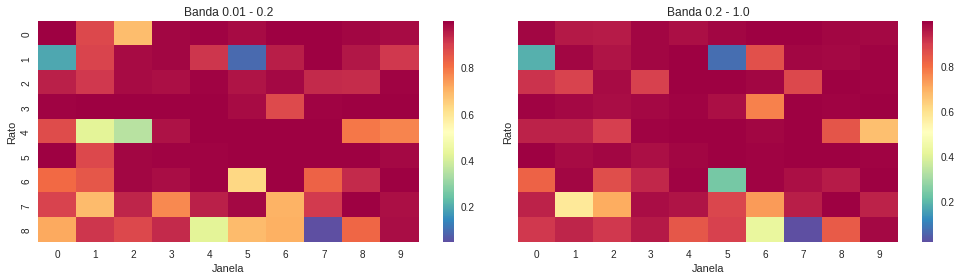

In [ ]:
fig, axs = plt.subplots(1, len(bandas_definition), figsize=(14, 4), sharex=True, sharey=True)
for i in range(len(bandas_definition)):
    sns.heatmap(bandas[i], ax=axs[i], cmap='Spectral_r')
    axs[i].set_title('Banda ' + str(bandas_definition[i][0]) + ' - ' + str(bandas_definition[i][1]) )
    axs[i].set_ylabel('Rato')
    axs[i].set_xlabel('Janela')
plt.tight_layout()

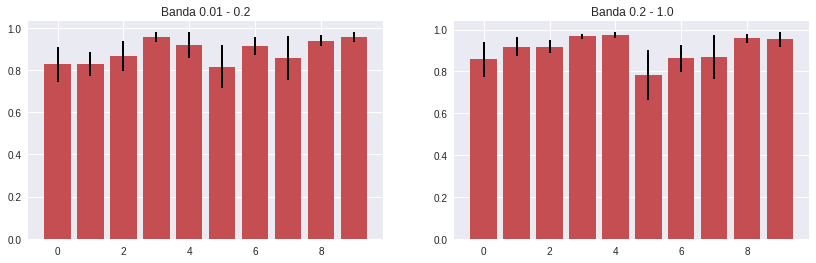

In [ ]:
fig, axs = plt.subplots(1, len(bandas_definition), figsize=(14, 4), sharex=True)

for banda in range(len(bandas)):
    for i in range(len(ratos)):
        df = pd.DataFrame(data=bandas[banda], columns=janelas)
        axs[banda].bar( np.arange(0, len(janelas), 1), df.mean(), yerr=stats.sem(df.values, axis=0) );
        axs[banda].set_title('Banda ' + str(bandas_definition[banda][0]) + ' - ' + str(bandas_definition[banda][1]) )


In [ ]:
heatmaps = len(bandas_definition)
bandas = []

for banda in bandas_definition:
    banda_values = np.zeros(( len(ratos), len(janelas) ))
    for i in range(len(ratos)):
        for j in range(len(janelas)):
            low, _ = find_nearest( results2[ ratos[i] ]['fxx'][0], banda[0] )
            high, _ = find_nearest( results2[ ratos[i] ]['fxx'][0], banda[1] )
            banda_values[i, j] = np.mean( results2[ ratos[i] ][janelas[j]][0][low:high, 1, 0 ] )
    bandas.append( banda_values )

NameError: ignored

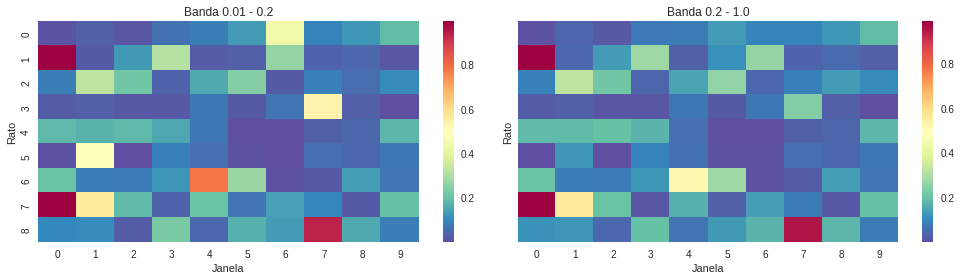

In [ ]:
fig, axs = plt.subplots(1, len(bandas_definition), figsize=(14, 4), sharex=True, sharey=True)
for i in range(len(bandas_definition)):
    sns.heatmap(bandas[i], ax=axs[i], cmap='Spectral_r')
    axs[i].set_title('Banda ' + str(bandas_definition[i][0]) + ' - ' + str(bandas_definition[i][1]) )
    axs[i].set_ylabel('Rato')
    axs[i].set_xlabel('Janela')
plt.tight_layout()

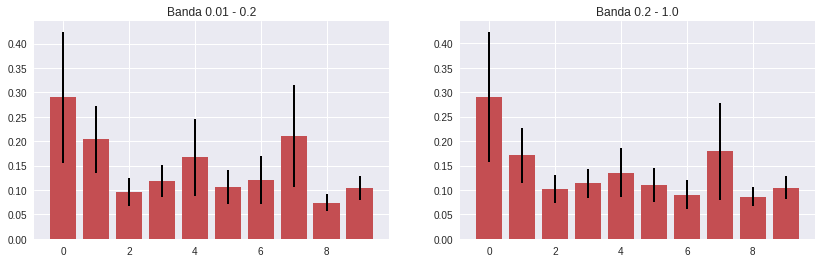

In [ ]:
fig, axs = plt.subplots(1, len(bandas_definition), figsize=(14, 4), sharex=True)

for banda in range(len(bandas)):
    for i in range(len(ratos)):
        df = pd.DataFrame(data=bandas[banda], columns=janelas)
        axs[banda].bar( np.arange(0, len(janelas), 1), df.mean(), yerr=stats.sem(df.values, axis=0) );
        axs[banda].set_title('Banda ' + str(bandas_definition[banda][0]) + ' - ' + str(bandas_definition[banda][1]) )


# Exp Sangue

In [ ]:
# 'R2462', R2464 R2473 R2474 R2475 'R2476' 'R2477', 'R2545', 'R2546'
#
ratos = ['R2450', 'R2461', 'R2480', 'R2462', 'R2464', 'R2473', 'R2474', 'R2475', 'R2476', 'R2477', 'R2545', 'R2546' ]
janelas = ['j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'j7', 'j8', 'j9', 'j10', 'j11', 'j12' ]
nperseg = 40000

In [ ]:
filename

'/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2462/R2462_j1.csv'

In [ ]:
data_df = pd.read_csv('/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2473/R2473_j1.csv', skiprows=9, sep=None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
data_df.head()

53100.0019  108.9539  -2.904164
0  53100.0039  108.6828  -1.863622
1  53100.0059  107.7977  -1.516774
2  53100.0079  107.0334  -1.371582
3  53100.0099  106.8015  -1.266721
4  53100.0119  106.4291  -1.500642

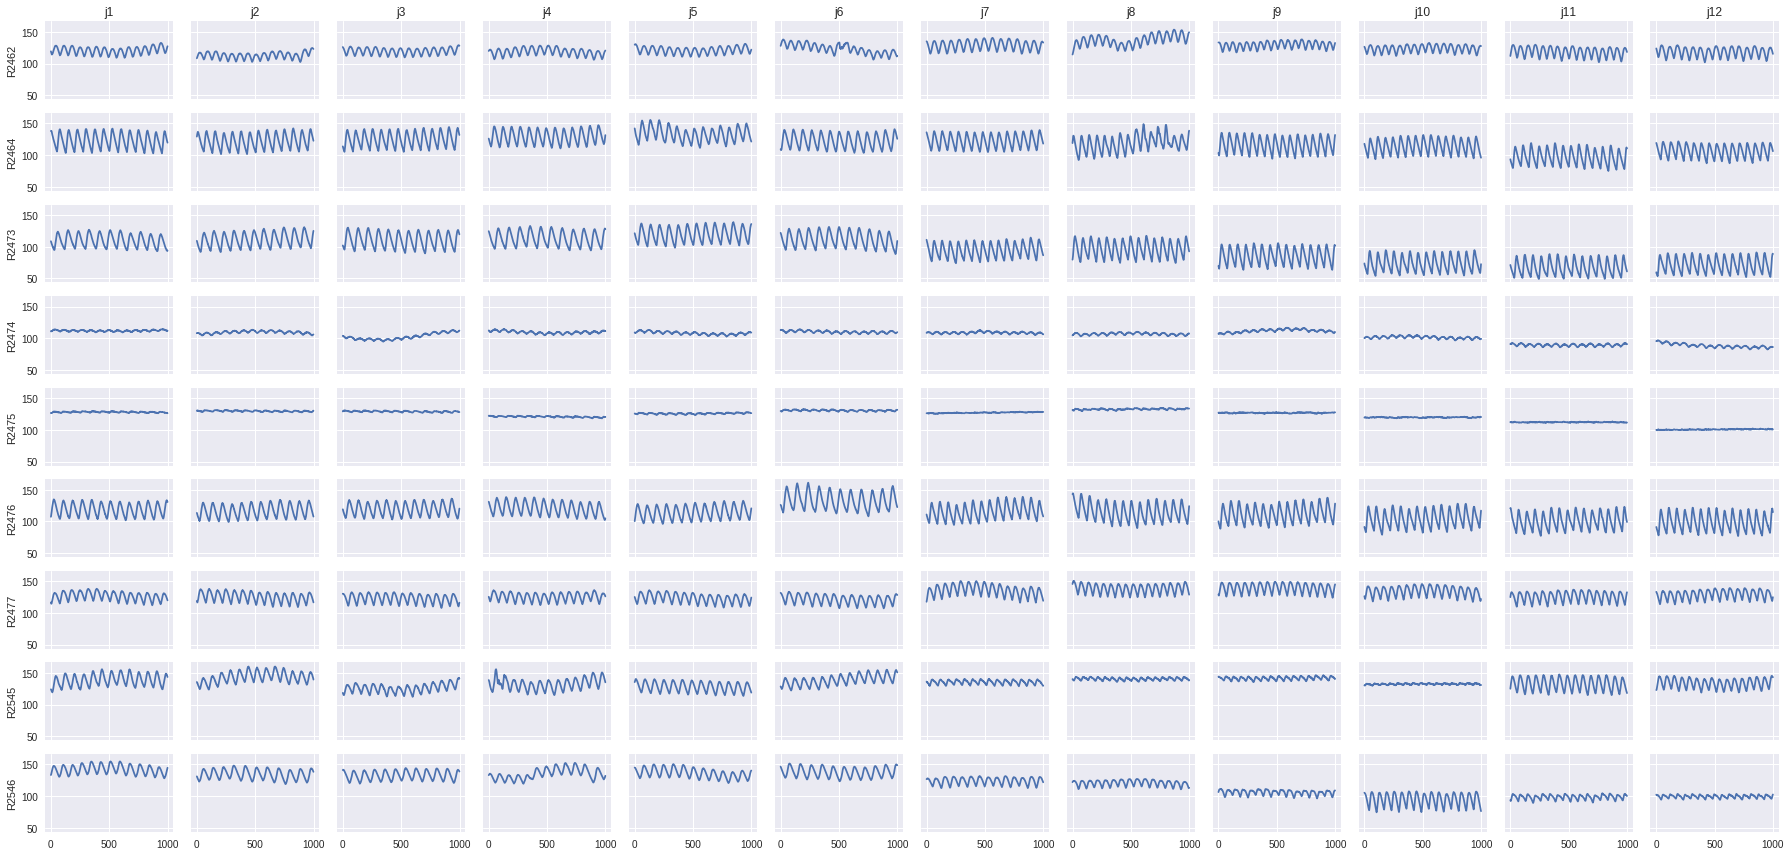

In [ ]:
# fluxo
fig, axs = plt.subplots(len(ratos), len(janelas), figsize=(25, 12), sharex=True, sharey=True)
for i in range(len(ratos)):
    for j in range(len(janelas)):
        filename = '/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/' + ratos[i] + '/'+ ratos[i] + '_' + janelas[j]+'.csv'
        my_file = Path(filename)
        if my_file.is_file():
            data_df = pd.read_csv(filename, skiprows=9, sep=None, engine='python')
            data = data_df.values
            axs[i, j].plot( data[0:1000, 1] )

for i in range(len(ratos)):
    axs[i,0].set_ylabel(ratos[i])
for k in range(len(janelas)):
    axs[0,k].set_title(janelas[k])
plt.tight_layout()

In [ ]:
my_file

PosixPath('/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2546/R2546 j12.csv')

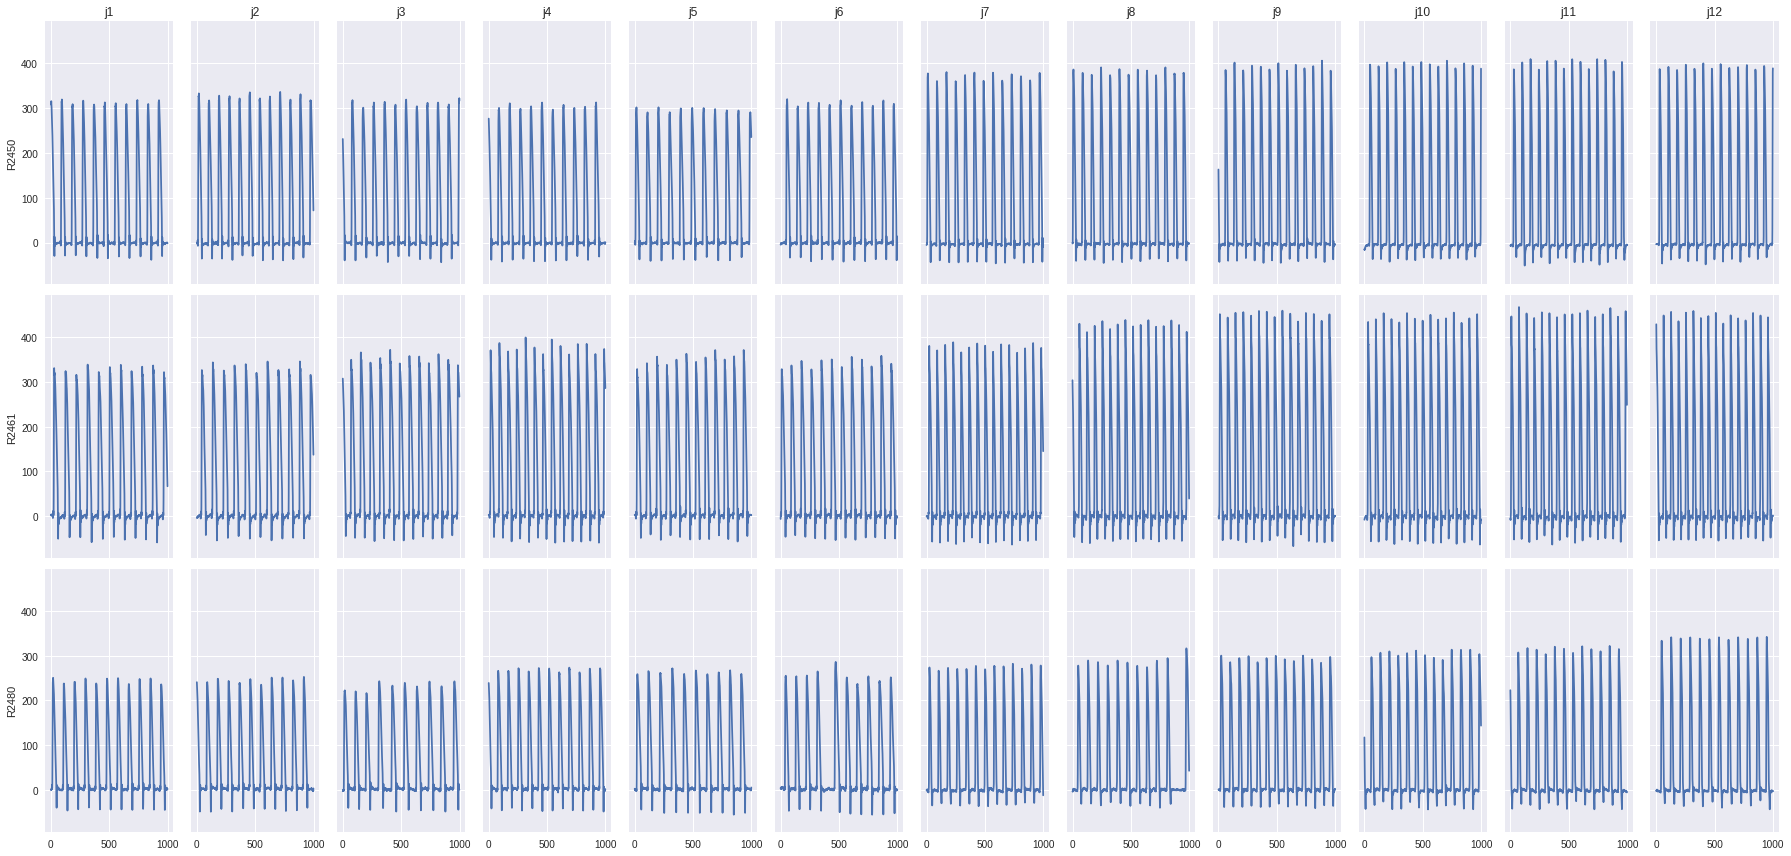

In [ ]:
# fluxo
fig, axs = plt.subplots(len(ratos), len(janelas), figsize=(25, 12), sharex=True, sharey=True)
for i in range(len(ratos)):
    for j in range(len(janelas)):
        filename = '/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/' + ratos[i] + '/'+ ratos[i] + ' ' + janelas[j]+'.csv'
        my_file = Path(filename)
        if my_file.is_file():
            data_df = pd.read_csv(filename, skiprows=9, sep=None, engine='python')
            data = data_df.values
            axs[i, j].plot( data[0:1000, 2] )

for i in range(len(ratos)):
    axs[i,0].set_ylabel(ratos[i])
for k in range(len(janelas)):
    axs[0,k].set_title(janelas[k])
plt.tight_layout()

In [ ]:
#fig, axs = plt.subplots(len(ratos), len(janelas), figsize=(25, 12), sharex=True, sharey=True)
h = signal.firwin(100, [0.01, 1.2], pass_zero=False, fs=500)

results = {}
for i in range(len(ratos)):
    results[ratos[i]] = {}
    results[ratos[i]]['fxx'] = []
    for j in range(len(janelas)):
        results[ratos[i]][janelas[j]] = []

results2 = {}
for i in range(len(ratos)):
    results2[ratos[i]] = {}
    results2[ratos[i]]['fxx'] = []
    for j in range(len(janelas)):
        results2[ratos[i]][janelas[j]] = []

for i in range(len(ratos)):
    for j in range(len(janelas)):
        filename = '/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/' + ratos[i] + '/'+ ratos[i] + '_' + janelas[j]+'.csv'
        my_file = Path(filename)
        if my_file.is_file():
            data_df = pd.read_csv(filename, skiprows=9, sep=None, engine='python')
            data = data_df.values
            print(filename, data.shape)

            sinal1 = signal.filtfilt(h, 1, data[0:150000, 2] )
            sinal2 = signal.filtfilt(h, 1, data[0:150000, 1] )
            sinal1 = sinal1 - np.mean(sinal1)
            sinal2 = sinal2 - np.mean(sinal2)
            mv = cp.Mvar
            best, crit = mv.order_akaike(np.array([sinal1, sinal2]), 15, 'vm')
            av, vf = mv.fit(np.array([sinal1, sinal2]), best, 'vm')
            pdc = cp.conn.gPDC()
            pdcval = pdc.calculate(av, vf, 500, 5000)

            fq, k, k = pdcval.shape
            freqs = np.linspace(0, 500*0.5, fq)

            results[ratos[i]][janelas[j]].append(pdcval[:, 0, 1])
            results2[ratos[i]][janelas[j]].append(pdcval[:, 1, 0])
            results[ratos[i]]['fxx'].append(freqs)
            results2[ratos[i]]['fxx'].append(freqs)

            #cp.plot_conn(pdcval, 'PDC values', 500)
            #connectivity.spectral_connectivity()
            #f, Cxy = signal.coherence(, 500, nperseg=4096*2)
            #axs[i,j].plot(c.frequencies, partial_directed_coherence[0, :, 0, 1], label='PDC',
            #        linewidth=2, alpha=0.8)
            #results[ratos[i]]['fxx'].append(f)
            #results[ratos[i]][janelas[j]].append(Cxy)
            #axs[i, j].plot( f[0:20], Cxy[0:20])

#for i in range(len(ratos)):
#    axs[i,0].set_ylabel(ratos[i])
#for k in range(len(janelas)):
#    axs[0,k].set_title(janelas[k])
#plt.tight_layout()



/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2450/R2450_j1.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2450/R2450_j2.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2450/R2450_j3.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2450/R2450_j4.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2450/R2450_j5.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2450/R2450_j6.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2450/R2450_j7.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2450/R2450_j8.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2450/R2450_j9.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2450/R2450_j10.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp san

/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.7/dist-packages/connectivipy/conn.py:710: RuntimeWarning: invalid value encountered in true_divide
  PDC[i] = np.abs(A_z[i]/np.sqrt(sigma))/np.sqrt(np.diag(mA))


/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2462/R2462_j2.csv (914924, 4)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2462/R2462_j3.csv (914924, 4)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2462/R2462_j4.csv (914924, 4)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2462/R2462_j5.csv (914924, 4)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2462/R2462_j6.csv (914924, 4)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2462/R2462_j7.csv (120472, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2462/R2462_j8.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2462/R2462_j9.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2462/R2462_j10.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/R2462/R2462_j11.csv (149999, 3)
/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sa

In [ ]:
results[list(results.keys())[0]]['fxx']

[]

In [ ]:
results_save = {}
results_save['freq'] = results[list(results.keys())[0]]['fxx'][0][0:21]
for janela in janelas:
    for key in results.keys():
        results_save[str(key) + janela] = results[key][janela][0][0:21]
pd.DataFrame.from_dict(results_save).to_csv('pdc_fluxo_pressao_sangue.csv')

In [ ]:
results_save = {}
results_save['freq'] = results[list(results.keys())[0]]['fxx'][0][0:21]
for janela in janelas:
    for key in results.keys():
        results_save[str(key) + janela] = results2[key][janela][0][0:21]
pd.DataFrame.from_dict(results_save).to_csv('pdc_pressao_fluxo_sangue.csv')

## Exp Sangue - Coh

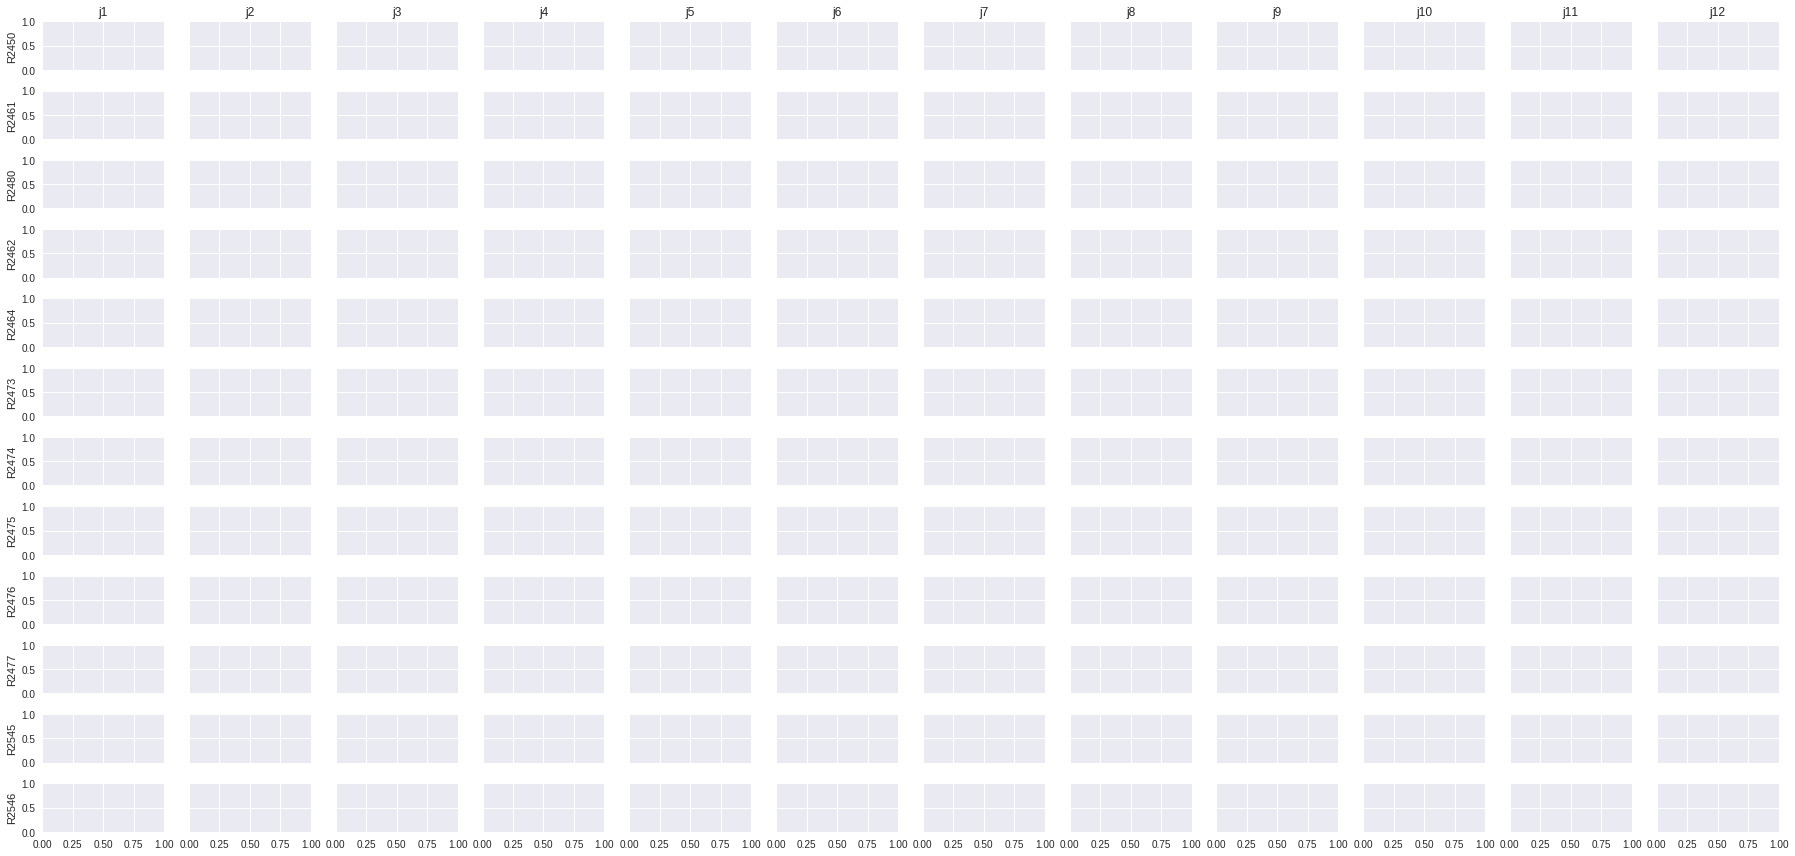

In [ ]:
fig, axs = plt.subplots(len(ratos), len(janelas), figsize=(25, 12), sharex=True, sharey=True)
h = signal.firwin(100, [0.01, 1.2], pass_zero=False, fs=500)

results = {}
for i in range(len(ratos)):
    results[ratos[i]] = {}
    results[ratos[i]]['fxx'] = []
    for j in range(len(janelas)):
        results[ratos[i]][janelas[j]] = []

for i in range(len(ratos)):
    for j in range(len(janelas)):
        filename = '/content/drive/Shareddrives/Hemodynamic/PDC_Janelas_exp sangue/' + ratos[i] + '/'+ ratos[i] + '_' + janelas[j]+'.csv'
        my_file = Path(filename)
        if my_file.is_file():
            data_df = pd.read_csv(filename, skiprows=9, sep=None, engine='python')
            data = data_df.values
            sinal1 = signal.filtfilt(h, 1, data[0:150000, 2] )
            sinal2 = signal.filtfilt(h, 1, data[0:150000, 1] )

            f, Cxy = signal.coherence(sinal1, sinal2, 500, nperseg=4096*4)

            results[ratos[i]]['fxx'].append(f)
            results[ratos[i]][janelas[j]].append(Cxy)
            #axs[i, j].plot( float(f[0:20]), float(abs(Cxy[0:20])))

for i in range(len(ratos)):
    axs[i,0].set_ylabel(ratos[i])
for k in range(len(janelas)):
    axs[0,k].set_title(janelas[k])
plt.tight_layout()

In [ ]:
results_save = {}
results_save['freq'] = results[ list(results.keys())[0] ] ['fxx'][0][0:33]
for janela in janelas:
    for key in results.keys():
        results_save[str(key) + janela] = results[key][janela][0][0:33]
pd.DataFrame.from_dict(results_save).applymap(np.absolute).to_csv('coh_16384.csv')

In [ ]:
data_df.head(10)

BottomValue=         *   -516.14
0    56700.0016  85.36537 -1.161861
1    56700.0036  85.23145 -2.742840
2    56700.0056  84.95056 -2.274999
3    56700.0076  84.68927 -0.492364
4    56700.0096  84.53902 -1.194125
5    56700.0116  84.23200  0.306192
6    56700.0136  83.97396  0.903092
7    56700.0156  83.85965 -0.564960
8    56700.0176  83.40238 -2.605714
9    56700.0196  83.19334 -3.597859

In [ ]:
data.shape

(150008, 3)

In [ ]:
plt.plot(results['1448']['j1'][0][:, 1, 0])

IndexError: ignored

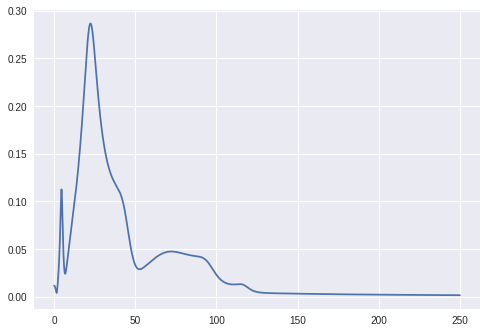

In [ ]:
plt.plot(freqs, results['1448']['j1'][0][:, 1, 0])

In [ ]:
fq, k, k = results['1448']['j1'][0].shape
freqs = np.linspace(0, 500*0.5, fq)

In [ ]:
freqs[8]

0.2000200020002

In [ ]:
freqs[40]

1.000100010001

In [ ]:
results['1448']['j1'][0].shape

(10000, 2, 2)

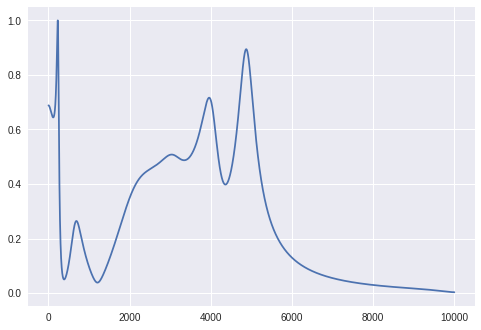

In [ ]:
plt.plot(pdcval[:, 1, 0])

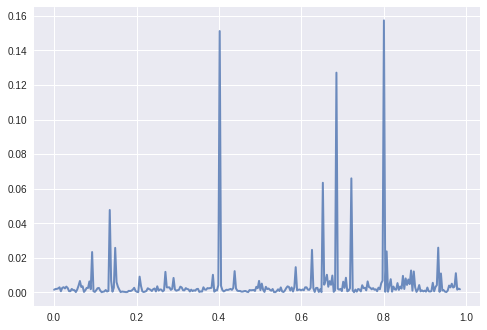

In [ ]:
plt.plot(c.frequencies[0:300], partial_directed_coherence[0, :, 1, 0][0:300], label='PDC',
                    linewidth=2, alpha=0.8)

/usr/local/lib/python3.7/dist-packages/connectivipy/mvar/fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


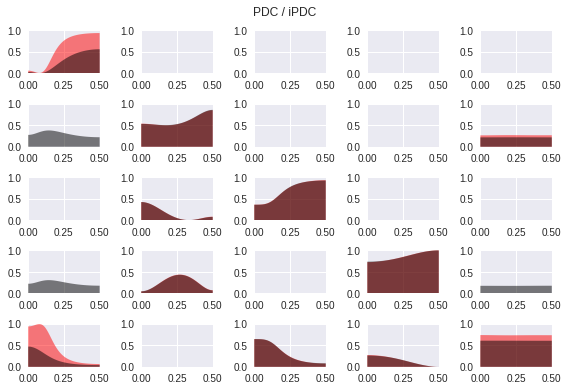

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import connectivipy as cp

"""
This example reproduce simulation from article:
Erla S et all (2009) "Multivariate autoregressive model with
                      instantaneous effects to improve brain
                      connectivity estimation"
"""

# let's make a matrix from original article

bcf = np.zeros((4, 5, 5))
# matrix shape meaning (k, k, p) k - number of channels,
# p - order of mvar parameters
bcf[1, 0, 0] = 1.58
bcf[2, 0, 0] = -0.81
bcf[0, 1, 0] = 0.9
bcf[2, 1, 1] = -0.01
bcf[3, 1, 4] = -0.6
bcf[1, 2, 1] = 0.3
bcf[1, 2, 2] = 0.8
bcf[2, 2, 1] = 0.3
bcf[2, 2, 2] = -0.25
bcf[3, 2, 1] = 0.3
bcf[0, 3, 1] = 0.9
bcf[1, 3, 1] = -0.6
bcf[3, 3, 1] = 0.3
bcf[1, 4, 3] = -0.3
bcf[2, 4, 0] = 0.9
bcf[2, 4, 3] = -0.3
bcf[3, 4, 2] = 0.6

# now we build a corresponding MVAR process without instantenous effect
L = np.linalg.inv(np.eye(5)-bcf[0])
acf = np.zeros((3, 5, 5))
for i in range(3):
    acf[i] = np.dot(L, bcf[i+1])

# generate 5-channel signals from matrix above
signal_inst = cp.mvar_gen_inst(bcf, int(10e4))
signal = cp.mvar_gen(acf, int(10e4))

# fit MVAR parameters
bv, vfb = cp.Mvar.fit(signal_inst, 3, 'yw')

av, vfa = cp.Mvar.fit(signal, 3, 'yw')

# use connectivity estimators
ipdc = cp.conn.iPDC()
ipdcval = ipdc.calculate(bv, vfb, 1.)

pdc = cp.conn.PDC()
pdcval = pdc.calculate(av, vfa, 1.)

def plot_double_conn(values_a, values_b, name='', fs=1, ylim=None, xlim=None, show=True):
    "function to plot two sets of connectivity values"
    fq, k, k = values_a.shape
    fig, axes = plt.subplots(k, k)
    freqs = np.linspace(0, fs*0.5, fq)
    if not xlim:
        xlim = [0, np.max(freqs)]
    if not ylim:
        ylim = [0, 1]
    for i in range(k):
        for j in range(k):
            axes[i, j].fill_between(freqs, values_b[:, i, j], 0, facecolor='red', alpha=0.5)
            axes[i, j].fill_between(freqs, values_a[:, i, j], 0, facecolor='black', alpha=0.5)
            axes[i, j].set_xlim(xlim)
            axes[i, j].set_ylim(ylim)
    plt.suptitle(name,y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    if show:
        plt.show()

plot_double_conn(pdcval**2, ipdcval**2, 'PDC / iPDC')



# Sinal Bruto

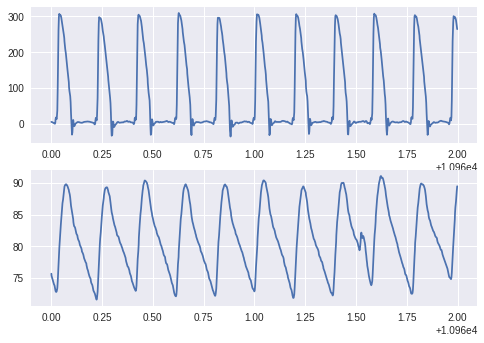

In [ ]:
plt.subplot(2,1, 1)
plt.plot(j3[0:1000, 0], j3[0:1000, 1])
plt.subplot(2,1,2)
plt.plot(j3[0:1000, 0], j3[0:1000, 2])

# Espectro Welch

Usando janelas de tamanho 1024, 2048 e 4096

Em baixo plot no log e no power sem transformação

In [ ]:
f1, Pxx_den1 = signal.welch(sinal1, fs=500, nperseg=1024, detrend='constant')
f2, Pxx_den2 = signal.welch(sinal2, fs=500, nperseg=1024, detrend='constant')

f1_2048, Pxx_den1_2048 = signal.welch(sinal1, fs=500, nperseg=2048, detrend='constant')
f2_2048, Pxx_den2_2048 = signal.welch(sinal2, fs=500, nperseg=2048, detrend='constant')

f1_4096, Pxx_den1_4096 = signal.welch(sinal1, fs=500, nperseg=4096, detrend='constant')
f2_4096, Pxx_den2_4096 = signal.welch(sinal2, fs=500, nperseg=4096, detrend='constant')

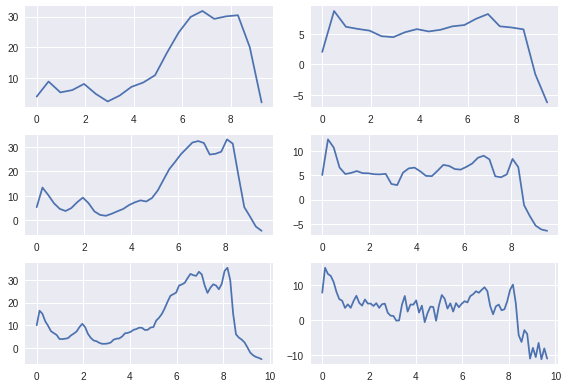

In [ ]:
plt.subplot(3,2, 1)
plt.plot( f1[0:20], np.log10(Pxx_den1[0:20])*10 )
plt.subplot(3,2, 2)
plt.plot(f2[0:20], np.log10(Pxx_den2[0:20])*10 )

plt.subplot(3,2, 3)
plt.plot( f1_2048[0:40], np.log10(Pxx_den1_2048[0:40])*10 )
plt.subplot(3,2, 4)
plt.plot(f2_2048[0:40], np.log10(Pxx_den2_2048[0:40])*10 )

plt.subplot(3,2, 5)
plt.plot( f1_4096[0:80], np.log10(Pxx_den1_4096[0:80])*10 )
plt.subplot(3,2, 6)
plt.plot(f2_4096[0:80], np.log10(Pxx_den2_4096[0:80])*10 )

plt.tight_layout()

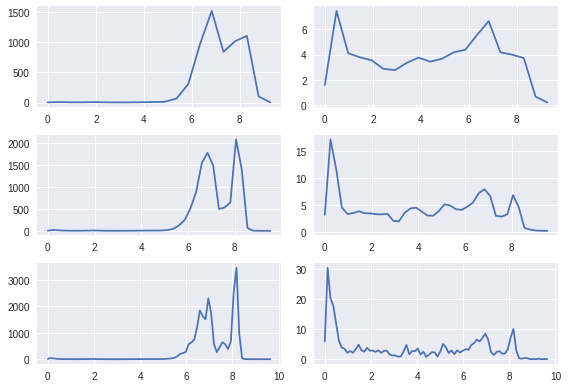

In [ ]:
plt.subplot(3,2, 1)
plt.plot( f1[0:20], Pxx_den1[0:20] )
plt.subplot(3,2, 2)
plt.plot(f2[0:20], Pxx_den2[0:20] )

plt.subplot(3,2, 3)
plt.plot( f1_2048[0:40], Pxx_den1_2048[0:40] )
plt.subplot(3,2, 4)
plt.plot(f2_2048[0:40], Pxx_den2_2048[0:40] )

plt.subplot(3,2, 5)
plt.plot( f1_4096[0:80], Pxx_den1_4096[0:80] )
plt.subplot(3,2, 6)
plt.plot(f2_4096[0:80], Pxx_den2_4096[0:80] )

plt.tight_layout()

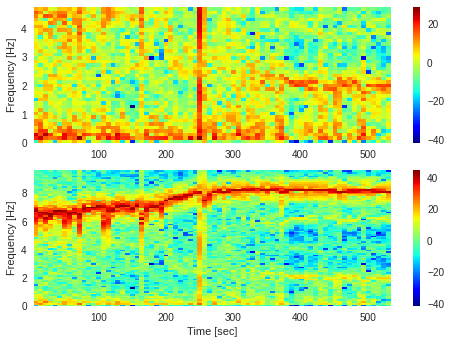

In [ ]:
f, t, Sxx = signal.spectrogram(sinal1, fs=500, nperseg=4096)

plt.subplot(2,1,1)
plt.pcolormesh(t, f[0:40], np.log10(Sxx[0:40])*10, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.colorbar()

plt.subplot(2,1,2)
plt.pcolormesh(t, f[0:80], np.log10(Sxx[0:80])*10, cmap='jet')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')
plt.colorbar()
plt.show()

# Analisando janelas 2 até 7

In [ ]:
espectros = {}
for file in ['j2', 'j3', 'j4', 'j5', 'j6', 'j7']:
    data = loadmat(file + '.mat')
    data = data[file]

    h = signal.firwin(100, [0.01, 10], pass_zero=False, fs=500)
    sinal1 = signal.filtfilt(h, 1, data[:,1])
    sinal2 = signal.filtfilt(h, 1, data[:,2])

    f1_4096, Pxx_den1_4096 = signal.welch(sinal1, fs=500, nperseg=4096, detrend='constant')
    f2_4096, Pxx_den2_4096 = signal.welch(sinal2, fs=500, nperseg=4096, detrend='constant')
    espectros[file] = []
    espectros[file].append( [f1_4096, Pxx_den1_4096, f2_4096, Pxx_den2_4096] )


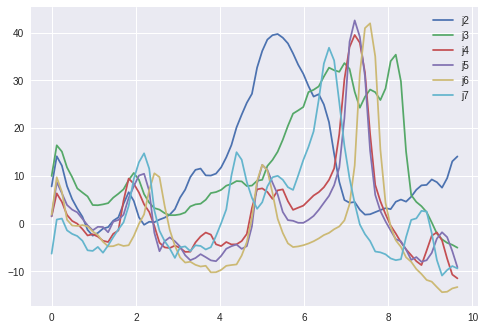

In [ ]:
for file in ['j2', 'j3', 'j4', 'j5', 'j6', 'j7']:
    plt.plot( espectros[file][0][0][0:80], np.log10(espectros[file][0][1][0:80])*10 )
    plt.legend(['j2', 'j3', 'j4', 'j5', 'j6', 'j7'])

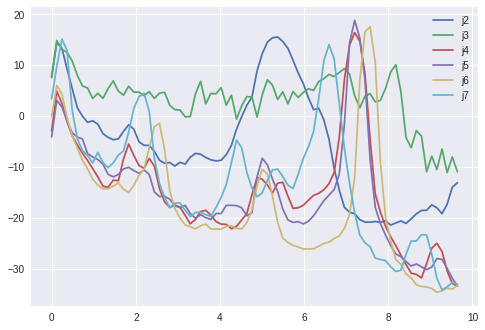

In [ ]:
for file in ['j2', 'j3', 'j4', 'j5', 'j6', 'j7']:
    plt.plot( espectros[file][0][2][0:80], np.log10(espectros[file][0][3][0:80])*10 )
    plt.legend(['j2', 'j3', 'j4', 'j5', 'j6', 'j7'])

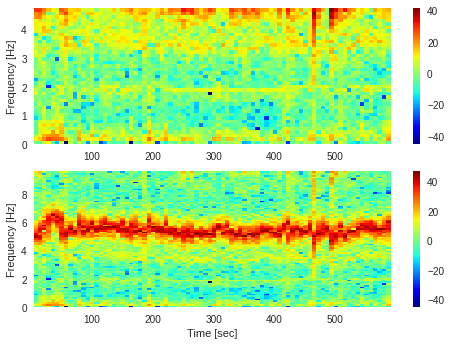

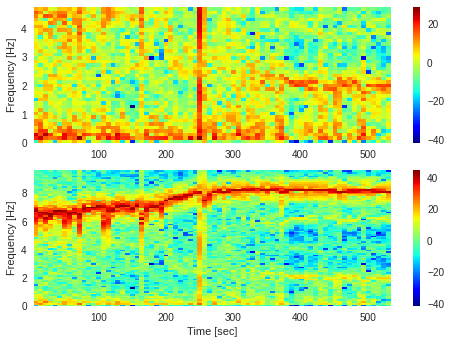

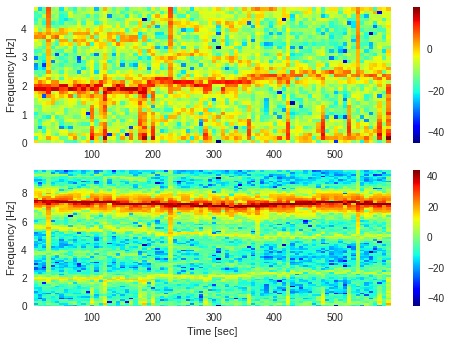

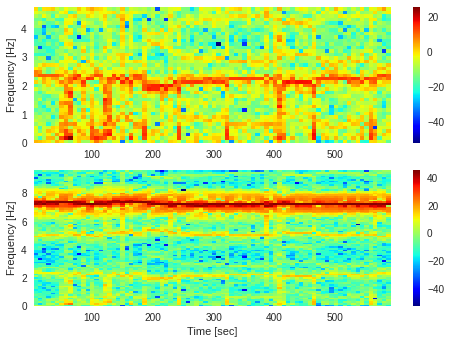

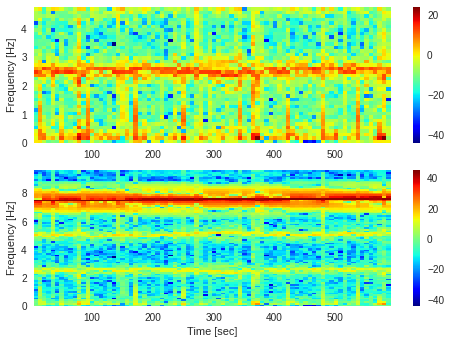

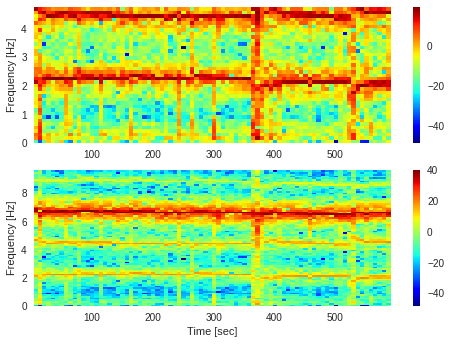

In [ ]:
for file in ['j2', 'j3', 'j4', 'j5', 'j6', 'j7']:
    data = loadmat(file + '.mat')
    data = data[file]

    h = signal.firwin(100, [0.01, 10], pass_zero=False, fs=500)
    sinal1 = signal.filtfilt(h, 1, data[:,1])
    sinal2 = signal.filtfilt(h, 1, data[:,2])
    spectrograma_hemo(sinal1)

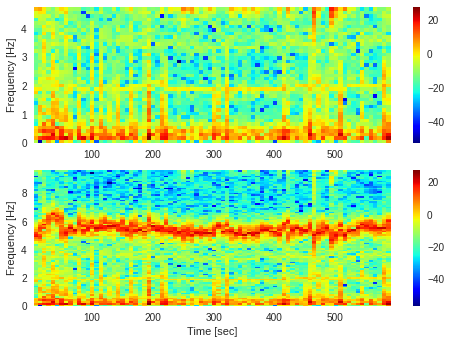

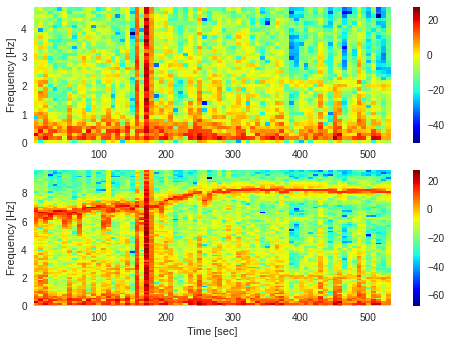

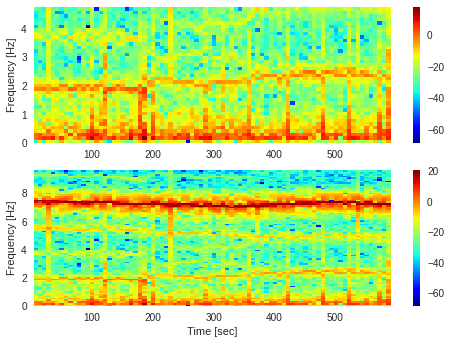

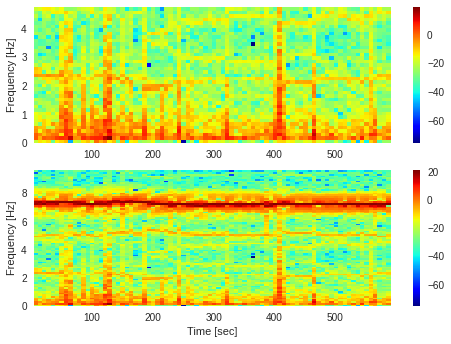

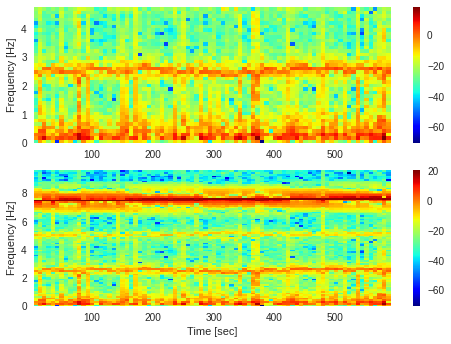

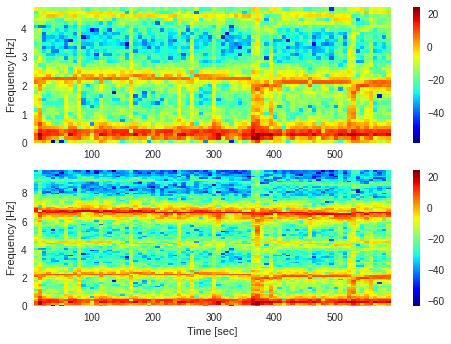

In [ ]:
for file in ['j2', 'j3', 'j4', 'j5', 'j6', 'j7']:
    data = loadmat(file + '.mat')
    data = data[file]

    h = signal.firwin(100, [0.01, 10], pass_zero=False, fs=500)
    sinal2 = signal.filtfilt(h, 1, data[:,2])
    spectrograma_hemo(sinal2)